# Trabajando con OpenCV. Líneas de seguimiento

Como primer ejemplo, extraeremos del suelo una línea guía (hecha de cinta negra adhesiva). Extraer la línea del suelo es un problema clásico en la robótica móvil, ya que es una de las referencias más importantes para la navegación de robots.
## 1. Instalando los componentes

In [1]:
# Instalamos las librerías necesarias

%pip install matplotlib opencv-python-headless


In [2]:
# Cargamos las librerías necesarias para la práctica
# https://docs.opencv.org/4.x/index.html
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
print ('Version CV '+cv2.__version__)

Version CV 4.11.0


## 2. Cargando la imagen

Cuando cargamos imágenes en OpenCV, se suele usar generalmente una representación como matrices de Numpy; Una dimensión por color.

De esta manera, una imagen en b/n de `542x959` se almacenará en un array de `542x959` y si está en color en una matriz `542x959x3` (RGB) 24 bits por pixel.


/content
(542, 959, 3)


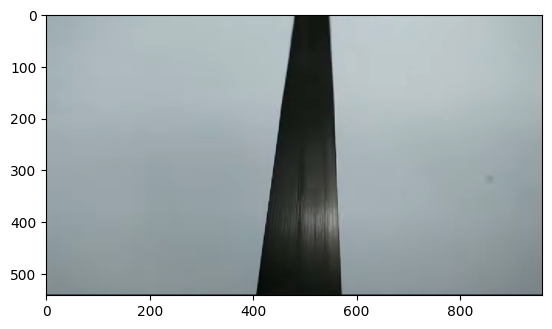

In [4]:
# Cargamos la imagen inicial:
current_path = os.getcwd()
print(current_path)
im = cv2.imread(current_path+'/1.-line.png')
print(im.shape)
plt.imshow(im)

## 3. Planificando la acción
Para planificar el movimiento, el robot solo necesita la información en la parte inferior de la imagen. Por esta razón, la imagen se puede cortar solo para que se procese la parte inferior.

Dado que la imagen tiene la forma de una matriz, se puede usar la notación de `slicing` de `NumPy` para cortar la imagen. Esto se hace con notación `img[y1:y2, x1:x2]` donde `y1` i `y2` son las coordenadas verticales y `x1` y `x2` las horizontales.

### 3.1 Cortando la imagen
La imagen original tiene un tamaño de `542x959` y queremos cortar la parte inferior de la imagen, por lo que queremos dejar la parte de la imagen que va de la fila `200` hasta la `542` y desde la Columna `0` hasta la `959`.

(342, 959, 3)


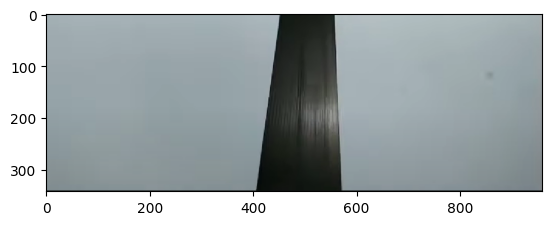

In [5]:
# Definir las coordenadas de corte
fila_inicio = 200
fila_fin = 542
columna_inicio = 0
columna_fin = 959
im_down = im[fila_inicio:fila_fin, columna_inicio:columna_fin]
print(im_down.shape)
plt.imshow(im_down)

### 3.2 Procesamos la imagen
Para realizar un seguimiento de la línea del suelo, primero debemos convertir la imagen en escala de grises.Podemos hacer esto con la función `cv2.cvtColor`.

In [5]:
im_bn = cv2.cvtColor(im_down, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)
plt.imshow(im_bn)

NameError: name 'im_down' is not defined

La imagen de la escala de grises es una imagen en la que cada píxel tiene un valor entre 0 y 255, donde 0 es negro y 255 es blanco. Esto nos permite trabajar con una sola dimensión y simplificar el procesamiento de la imagen.

Se muestra en colores para ver mejor, pero el procesamiento se realizará en escala de grises.

Aplicaremos un Gaussianblur para suavizar la imagen y eliminar el ruido. Podemos hacer esto con la función `cv2.GaussianBlur`.

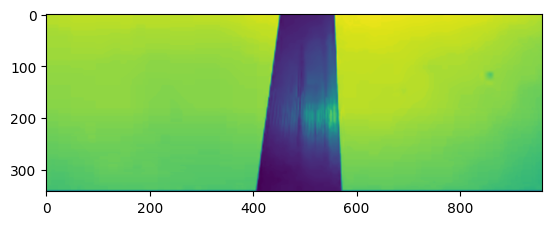

In [7]:
im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
# matriz de desenfoque de 5x5 0=desv. standard automática
plt.imshow(im_blurred)

### 3.3 Thresolding (umbral)

A continuación, haremos _thresolding_ (separar el fondo del primer plano).En este [artículo](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) podemos ver el procedimiento bien descrito.

El método más simple es el _Simple Thresholding_ que simplemente compara cada píxel con un valor y lo convierte en blanco o negro dependiendo de si es más grande o más pequeño. Este método es el más simple y más rápido. Este método se puede usar cuando la imagen está bien iluminada y el fondo es fácil de separar del primer plano.

cv2.threshold() - Esta función convierte una imagen en escala de grises a una imagen binaria (blanco y negro) basada en un valor umbral.

im_blurred - Es la imagen de entrada, que según el código anterior, es una imagen que ya ha sido procesada con un desenfoque gaussiano.

100 - Este es el valor umbral. Cualquier píxel con intensidad mayor que 100 será tratado de una manera, y los píxeles con intensidad menor o igual a 100 serán tratados de otra manera.

255 - Este es el valor máximo que se asignará a los píxeles que cumplan con la condición del umbral.

cv2.THRESH_BINARY_INV - Este parámetro especifica el tipo de umbralización. En este caso es una umbralización binaria invertida, lo que significa:


Si el valor del píxel es mayor que 100, se convierte a 0 (negro)
Si el valor del píxel es menor o igual a 100, se convierte a 255 (blanco)


En nuestro caso, hemos marcado el valor de _threshold_ a 100, pero se puede ajustar de acuerdo con la imagen.


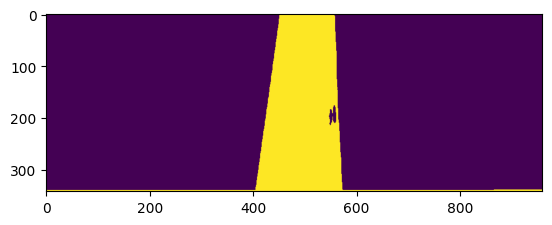

In [8]:
umbral = 130
ret, im_th = cv2.threshold(im_blurred,umbral,255,cv2.THRESH_BINARY_INV)
plt.imshow(im_th)
#haz varias simulaciones con diferentes niveles de umbral

### 3.4 Búsqueda de los bordes

Una vez que tenemos la imagen en BN puro, podemos buscar los bordes de la línea. Podemos hacer esto con la función `cv2.findContours`. Esta función devuelve una lista de bordes, que son una lista de puntos que componen el borde.

A medida que esta función transforma la imagen, haremos una copia de la imagen en BN para no perder la imagen original.

    contours, _ = ...

    contours: Este es el primer valor de retorno de cv2.findContours(). Es una lista de arrays de NumPy, donde cada array representa un contorno. Cada array contiene las coordenadas (x, y) de los puntos que forman el contorno.

    _: Este es el segundo valor de retorno de cv2.findContours(). Es una jerarquía opcional de contornos. La jerarquía describe la relación entre los contornos (por ejemplo, qué contornos están anidados dentro de otros). En este caso, se está ignorando este valor (usando _) porque no se está utilizando.



In [9]:
im_th_copy = im_th.copy()
contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)


### 3.5 Dibujamos el borde

Dado que solo estamos interesados ​​en el borde más grande, verificaremos si hay más de un borde y nos quedaremos con el más grande.

Una vez encontrado el borde, buscaremos el centro del borde. Podemos hacer esto con la función `cv2.moments`. Esta función devuelve un diccionario con los momentos de la imagen, que nos permiten calcular el centro del borde. Específicamente: `cX = M["m10"] / M["m00"]` i `cY = M["m01"] / M["m00"]`.

Finalmente, dibujaremos el borde en la imagen original. Podemos hacer esto con la función `cv2.drawContours` y `cv2.circle` para dibujar el centro del borde.

Para entender el significado de los momentos m00, m10 y m01, es útil saber que provienen de la teoría de los momentos de imagen. Estos momentos son características numéricas que describen la forma y la distribución de la intensidad de píxeles en una imagen.


Conceptos básicos:

- Los momentos de imagen se calculan como sumas ponderadas de las intensidades de los píxeles.
- La ponderación se basa en las coordenadas de los píxeles (x, y).
- Los momentos se clasifican por orden, que se indica mediante dos índices (p, q).

Significado de los momentos específicos:

- m00:
  Este es el momento de orden (0, 0).
  Representa el área total del contorno o la suma total de las intensidades de los píxeles en la región.
  En una imagen binaria (donde los píxeles son 0 o 1), m00 es simplemente el número de píxeles blancos (o el área del objeto).
- m10:
  Este es el momento de orden (1, 0).
  Se calcula ponderando las intensidades de los píxeles por sus coordenadas x.
  Ayuda a determinar la posición horizontal del centroide del objeto.
- m01:
  Este es el momento de orden (0, 1).
  Se calcula ponderando las intensidades de los píxeles por sus coordenadas y.
  Ayuda a determinar la posición vertical del centroide del objeto.

Uso en el cálculo del centroide:

Los momentos m10 y m01 se combinan con m00 para calcular las coordenadas del centroide (cx, cy):
        cx = m10 / m00
        cy = m01 / m00

El centroide es el centro de masa del objeto, y es una característica útil para el seguimiento de objetos y el análisis de formas.

- m00 te da el área.
- m10 y m01 te ayudan a encontrar el centro del objeto.

Centro en  496 186


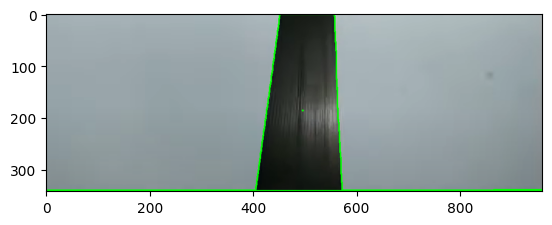

In [10]:
if len(contours) != 0:
    #Encuentra el contorno más grande (en términos de área)
    #dentro de la lista contours
    max_contour = max(contours, key = cv2.contourArea)

    #cv2.moments(max_contour): Esta función calcula los "momentos" del
    #contorno max_contour.
    #Los momentos son propiedades estadísticas
    #que describen la forma de un contorno.
    center = cv2.moments(max_contour)

    #Calculamos las coordenadas del centro del contorno
    cx = int(center['m10']/center['m00'])
    cy = int(center['m01']/center['m00'])
    print('Centro en ',cx, cy)

    #Dibujamos un círculo en el centro del contorno
    # 5 = radio del círculo
    # (0, 255, 0) color en formato RGB
    # -1 el círculo es relleno
    cv2.circle(im_down, (cx, cy), 2,  (0, 255, 0), -1)
    # 0 contorno a dibujar el 1º de max_contour
    # 2 grosor
    cv2.drawContours(im_down, [max_contour], 0, (0, 255, 0), 2)
    plt.imshow(im_down)

### 3.6 Movimiento
Finalmente, simulamos el movimiento del robot. Si el centro se encuestra a la izquierda o derecha más allá de un valor habría que actuar en consecuencia.
Si el centro de la carretera está a la derecha el borde es rojo, o  si está a la izquierda, azul.
Vamos a construir una función en la que compilamos todo lo visto anteriormente.


In [14]:
def procesar_imagen(im):
  fila_inicio = 200
  fila_fin = 542
  columna_inicio = 0
  columna_fin = 959
  im_down = im[fila_inicio:fila_fin, columna_inicio:columna_fin]
  im_bn = cv2.cvtColor(im_down, cv2.COLOR_BGR2GRAY)
  im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
  umbral = 130
  ret, im_th = cv2.threshold(im_blurred,umbral,255,cv2.THRESH_BINARY_INV)
  im_th_copy = im_th.copy()
  contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
  if len(contours) != 0:
    max_contour = max(contours, key = cv2.contourArea)
    center = cv2.moments(max_contour)

    #Calculamos las coordenadas del centro del contorno
    cx = int(center['m10']/center['m00'])
    cy = int(center['m01']/center['m00'])

    color = (0,255,0)
    if cx < 300:
      color = (0,0,255)
    elif cx > 600:
      color = (255,0,0)
    print("Centro carretera en ",cx)
    cv2.circle(im_down, (cx, cy), 2,  color, -1)
    cv2.drawContours(im_down, [max_contour], 0, color, 2)
    ancho = im_down.shape[1]
    # Calcular el centro horizontal
    centro_x = ancho // 2
    cv2.circle(im_down, (centro_x, cy), 3,  (0,255,0), -1)
    print("Centro imagen en ",centro_x)
  return im_down

/content
Centro carretera en  496
Centro imagen en  479


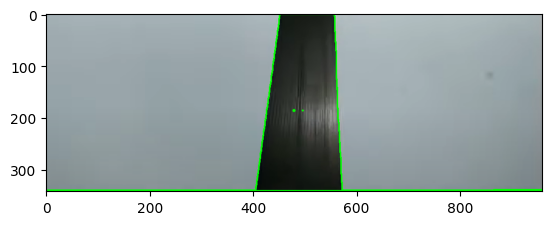

In [17]:
current_path = os.getcwd()
print(current_path)
im = cv2.imread(current_path+'/1.-line.png')
im_proc = procesar_imagen(im)
plt.imshow(im_proc)

/content
Centro carretera en  138
Centro imagen en  479


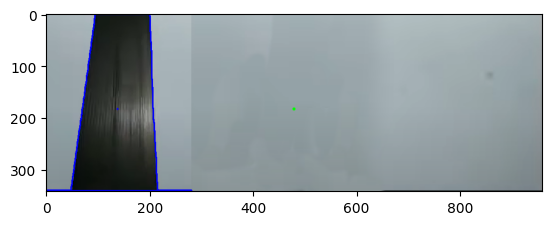

In [18]:
current_path = os.getcwd()
print(current_path)
im_left = cv2.imread(current_path+'/1.-line_left.png')
im_proc = procesar_imagen(im_left)
plt.clf()
plt.close('all')
plt.imshow(im_proc)

/content
Centro carretera en  818
Centro imagen en  479


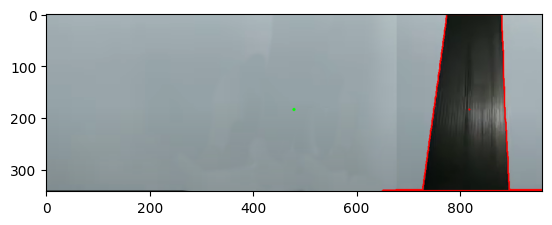

In [20]:
current_path = os.getcwd()
print(current_path)
im_right = cv2.imread(current_path+'/1.-line_right.png')
im_proc = procesar_imagen(im_right)
plt.clf()
plt.close('all')
plt.imshow(im_proc)